# Analysis on song degradation 

- Compare song features before and after deafening 
- Post-deafening songs were obtained from the last session where neural data are present 
- Use individual_syllable and syllable_pcc tables


In [1]:
from analysis.parameters import fr_crit, nb_note_crit
from database.load import ProjectLoader
from util import save
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Load database
db = ProjectLoader().load_db()

In [3]:
def compare_song_feature_pre_post(db, song_feature):

    # Get song features from pre & post (Undir)
    query = f"""SELECT syl.birdID, syl.taskName, song.taskSessionPostDeafening, syl.note, syl.entropy, syl.entropyVar AS ev
                FROM individual_syllable syl INNER JOIN song
                ON song.id = syl.songID WHERE syl.context='U'
            """
    df = db.to_dataframe(query)

    # Get post-deafening where neural data are present
    query = \
        f"""SELECT birdID, taskName, taskSessionPostDeafening, note, nbNoteUndir AS nbNotes, entropyUndir AS entropy,  entropyVarUndir AS ev
            FROM syllable_pcc
            WHERE frUndir >= {fr_crit} AND nbNoteUndir >={nb_note_crit}
            AND taskName='Postdeafening'
            """
    df_pcc = db.to_dataframe(query)
    last_day_dict = df_pcc.groupby('birdID')['taskSessionPostDeafening'].max().to_dict()

    df_results = pd.DataFrame() # store results here

    for bird, last_day in last_day_dict.items():
        # if bird == 'b70r38':
        df_post = df.loc[(df['birdID']==bird) & (df['taskSessionPostDeafening']==last_day)]
        nb_notes_dict = df_post.groupby('note').size().to_dict()
        for note, nb_notes_post in nb_notes_dict.items():
            if nb_notes_post >= nb_note_crit:
                df_note_pre = df.loc[(df['birdID']==bird) &
                                (df['taskName']=='Predeafening') &
                                (df['note'] == note)
                                 ]
                nb_notes_pre = len(df_note_pre)
                if nb_notes_pre < nb_note_crit: continue
                # Subsample so that # of notes are equal between pre and post
                if nb_notes_pre < nb_notes_post:
                    pre_data, post_data = \
                        df_note_pre[song_feature].values, \
                        df_post.loc[df_post['note']==note].sample(n=nb_notes_pre, random_state=1)[song_feature].values
                else:
                    pre_data, post_data = \
                        df_note_pre.sample(n=nb_notes_post, random_state=1)[song_feature].values, \
                        df_post.loc[df_post['note'] == note][song_feature].values
                # print(len(pre_data), len(post_data))
                # print(f"{pre_data.mean() :.3f}, {post_data.mean() :.3f}")

                # rank-sum test (two-sample non-parametric test)
                from scipy.stats import ranksums
                if song_feature == 'entropy':
                    stat, pval = ranksums(pre_data, post_data, alternative='less')
                elif  song_feature == 'ev':
                    stat, pval = ranksums(pre_data, post_data, alternative='greater')

                # degree_of_freedom = len(pre_data) + len(pre_data) - 2
                # if pval < 0.001:  # mark significance
                #     msg = f"ranksum Z={stat : .3f}, p < 0.001"
                # else:
                #     msg = f"ranksum Z={stat : .3f}, p={pval : .3f}"

                # Organize results
                df_temp = pd.DataFrame({'birdID' : [bird],
                                        'note': [note],
                                        'nbNotes' : [len(pre_data)],
                                        song_feature + 'Pre': [round(pre_data.mean(), 3)],
                                        song_feature + 'Post': [round(post_data.mean(), 3)],
                                        'postSessionDeafening': [last_day],
                                        'sig': [pval<0.05],
                                        })
                df_results = df_results.append(df_temp, ignore_index=True)

    return df_results



In [2]:
def plot_song_feature_pre_post_stats(df, song_feature, x_lim=None, y_lim=None):

    # plot_song_feature_pre_post_stats
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from util.draw import remove_right_top

    # Loop through birds to plot all notes
    dot_size = 60
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    # Plot scatter
    sns.scatterplot(np.zeros(len(df)), df[song_feature + 'Pre'],
                    s=dot_size, color='k', ax=ax)

    sns.scatterplot(np.ones(len(df)) * df['postSessionDeafening'],
                    df[song_feature + 'Post'],
                    s=dot_size, color='k', ax=ax)


    for _, row in df.iterrows():
        color = 'm-' if row['sig'] else 'k-'  # mark significance in magenta
        ax.plot([0, row['postSessionDeafening']],
                [row[song_feature + 'Pre'], row[song_feature + 'Post']],
                color, linewidth=1)

    remove_right_top(ax)
    if x_lim:
        ax.set_xlim(x_lim)
    if y_lim:
        ax.set_ylim(y_lim)
    ax.set_xlabel('Days after deafening')
    ax.set_ylabel(song_feature)
    plt.suptitle(f"""Pre vs. Last day of neural recording after deafening \n
                    \n # of notes = {len(df)} ({df['sig'].sum()} /{len(df_results)})""", y=1, fontsize=10)
    plt.show()


## Entropy

• Marked syllables that changed differently from pre-deafening (magenta).

• 2-sample rank-sum test (one-tailed, alpha = 0.05).


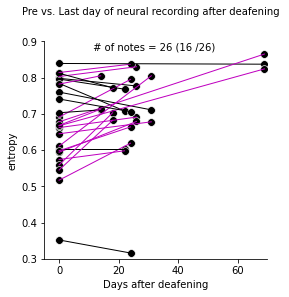

In [4]:
df_results = compare_song_feature_pre_post(db, song_feature='entropy')
plot_song_feature_pre_post_stats(df_results, song_feature='entropy',
                                 x_lim=[-5, 70], y_lim=[0.3, 0.9]
                                 )

## Entropy Variance

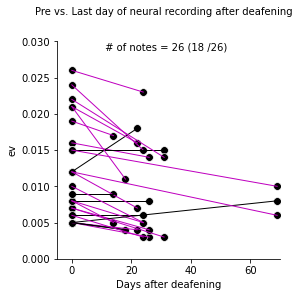

In [73]:
df_results = compare_song_feature_pre_post(db, song_feature='ev')
plot_song_feature_pre_post_stats(df_results, song_feature='ev',
                                 x_lim=[-5, 70], y_lim=[0, 0.03]
                                 )

In [74]:
# Get song features from pre & post (Undir)
query = f"""SELECT syl.birdID, syl.taskName, song.taskSessionPostDeafening, syl.note, syl.entropy, syl.entropyVar AS ev
            FROM individual_syllable syl INNER JOIN song
            ON song.id = syl.songID WHERE syl.context='U'
        """
df = db.to_dataframe(query)

In [75]:
# Get post-deafening where neural data are present
query = \
    f"""SELECT birdID, taskName, taskSessionPostDeafening, block10days, note, nbNoteUndir AS nbNotes, entropyUndir AS entropy,  entropyVarUndir AS ev
        FROM syllable_pcc
        WHERE frUndir >= {fr_crit} AND nbNoteUndir >={nb_note_crit}
        AND taskName='Postdeafening' 
        AND block10days=1
        """
df_pcc = db.to_dataframe(query)

In [77]:
df_pcc

,birdID,taskName,taskSessionPostDeafening,block10days,note,nbNotes,entropy,ev
0,b70r38,Postdeafening,10,1,a,29,0.479,0.02317
1,b70r38,Postdeafening,10,1,b,29,0.535,0.01186
2,b70r38,Postdeafening,10,1,c,29,0.797,0.01465
3,b70r38,Postdeafening,10,1,d,27,0.718,0.01374
4,w16w14,Postdeafening,4,1,a,161,0.826,0.00618
5,w16w14,Postdeafening,4,1,b,103,0.725,0.01644
6,w16w14,Postdeafening,4,1,c,97,0.686,0.01286
7,w16w14,Postdeafening,7,1,a,77,0.813,0.00657
8,w16w14,Postdeafening,7,1,b,50,0.737,0.01418
9,w16w14,Postdeafening,7,1,c,52,0.700,0.00981


In [85]:
last_day_dict = df_pcc.groupby(['birdID', 'block10days', 'note']).count()
last_day_dict

taskName  taskSessionPostDeafening  nbNotes  entropy  \
birdID block10days note                                                         
b70r38 1           a            1                         1        1        1   
                   b            1                         1        1        1   
                   c            1                         1        1        1   
                   d            1                         1        1        1   
w16w14 1           a            3                         3        3        3   
                   b            3                         3        3        3   
                   c            3                         3        3        3   
y44r34 1           a            1                         1        1        1   
                   b            1                         1        1        1   
                   d            1                         1        1        1   

                         ev  
birdID block10days note      
b70r38 1           a      1  
                   b      1  
                   c      1  
                   d      1  
w16w14 1           a      3  
                   b      3  
                   c      3  
y44r34 1           a      1  
                   b      1  
                   d      1

In [9]:
df_results = pd.DataFrame() # store results here
last_day_dict = df_pcc.groupby('birdID')['block10days'].to_dict()

for bird, last_day in last_day_dict.items():
    # if bird == 'b70r38':
    df_post = df.loc[(df['birdID']==bird) & (df['block10days']==last_day)]
    nb_notes_dict = df_post.groupby('note').size().to_dict()
    for note, nb_notes_post in nb_notes_dict.items():
        if nb_notes_post >= nb_note_crit:
            df_note_pre = df.loc[(df['birdID']==bird) &
                            (df['taskName']=='Predeafening') &
                            (df['note'] == note)
                             ]
            nb_notes_pre = len(df_note_pre)
            if nb_notes_pre < nb_note_crit: continue
            # Subsample so that # of notes are equal between pre and post
            if nb_notes_pre < nb_notes_post:
                pre_data, post_data = \
                    df_note_pre[song_feature].values, \
                    df_post.loc[df_post['note']==note].sample(n=nb_notes_pre, random_state=1)[song_feature].values
            else:
                pre_data, post_data = \
                    df_note_pre.sample(n=nb_notes_post, random_state=1)[song_feature].values, \
                    df_post.loc[df_post['note'] == note][song_feature].values
            # print(len(pre_data), len(post_data))
            # print(f"{pre_data.mean() :.3f}, {post_data.mean() :.3f}")

            # rank-sum test (two-sample non-parametric test)
            from scipy.stats import ranksums
            if song_feature == 'entropy':
                stat, pval = ranksums(pre_data, post_data, alternative='less')
            elif  song_feature == 'ev':
                stat, pval = ranksums(pre_data, post_data, alternative='greater')

            # degree_of_freedom = len(pre_data) + len(pre_data) - 2
            # if pval < 0.001:  # mark significance
            #     msg = f"ranksum Z={stat : .3f}, p < 0.001"
            # else:
            #     msg = f"ranksum Z={stat : .3f}, p={pval : .3f}"

            # Organize results
            df_temp = pd.DataFrame({'birdID' : [bird],
                                    'note': [note],
                                    'nbNotes' : [len(pre_data)],
                                    song_feature + 'Pre': [round(pre_data.mean(), 3)],
                                    song_feature + 'Post': [round(post_data.mean(), 3)],
                                    'postSessionDeafening': [last_day],
                                    'sig': [pval<0.05],
                                    })
            df_results = df_results.append(df_temp, ignore_index=True)

In [63]:
df_pcc.head()

,birdID,taskName,taskSessionPostDeafening,block10days,note,nbNotes,entropy,ev
0,b70r38,Postdeafening,10,1,a,29,0.479,0.02317
1,b70r38,Postdeafening,10,1,b,29,0.535,0.01186
2,b70r38,Postdeafening,10,1,c,29,0.797,0.01465
3,b70r38,Postdeafening,10,1,d,27,0.718,0.01374
4,b70r38,Postdeafening,15,2,a,22,0.471,0.02964
